In [6]:
# Load generated answers and uncertainty measures
import pickle

with open("../data/combined_uncertainty_measures_paraphrases_with_P_false.pkl", "rb") as file:
    uncertainty_results = pickle.load(file)
uncertainty_measures = uncertainty_results['uncertainty_measures']

with open("../data/combined_paraphrase_answers.pkl", "rb") as file:
    questions_answers = pickle.load(file)

In [3]:
print(uncertainty_results.keys())
print(uncertainty_measures.keys())
print(len(uncertainty_measures['original_p_false']), len(questions_answers))

dict_keys(['example_ids', 'original_semantic_ids', 'all_semantic_ids', 'is_false', 'unanswerable', 'uncertainty_measures'])
dict_keys(['original_cluster_assignment_entropy', 'all_cluster_assignment_entropy', 'original_regular_entropy', 'all_regular_entropy', 'original_semantic_entropy', 'all_semantic_entropy', 'original_p_false', 'all_p_false', 'original_p_false_fixed', 'all_p_false_fixed'])
1095 1095


In [4]:
# Calculate AUROC for each measure
from sklearn.metrics import roc_auc_score

# p_false v.s. p_false_fixed? I think 1-log(P(true)) vs 1-P(true)
methods = ['original_p_false_fixed', 'all_p_false_fixed', 'original_semantic_entropy', 'all_semantic_entropy']
method_clean_names = ['P(false)', 'Paraphrase P(false)', 'SE', 'Paraphrase SE']
AUROCs = []
for m in methods:
    AUROCs.append(roc_auc_score(uncertainty_results['is_false'], uncertainty_measures[m]))

print(AUROCs)

[0.766771538320834, 0.7657984269251875, 0.8167806841046277, 0.8197731845619168]


(0.6, 0.8607618437900126)

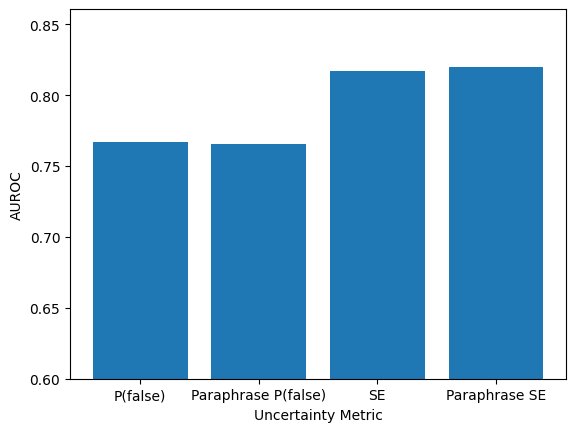

In [5]:
import matplotlib.pyplot as plt

plt.bar(method_clean_names, AUROCs)
plt.xlabel("Uncertainty Metric")
plt.ylabel("AUROC")
plt.ylim(bottom=0.6)

In [6]:
# Compare performances for different number of valid paraphrases

# Get number of valid questions for each example (original + 0-3 paraphrases)
num_q = [len(questions_answers[ex_id]['question_and_paraphrases']) for ex_id in uncertainty_results['example_ids']]

# Get list of indices with n valid question versions for n = 1, 2, 3, 4
indices_by_num_q = {1:[], 2:[], 3:[], 4:[]}
for i, num in enumerate(num_q):
    indices_by_num_q[num].append(i)

print({num: len(indices_by_num_q[num]) for num in range(1, 5)})

{1: 195, 2: 162, 3: 231, 4: 507}


In [7]:
# Calculate AUC for each metric on each subset of examples (grouped by number of questions)
auroc_by_num_q = {m: [] for m in ['original_semantic_entropy', 'all_semantic_entropy']}

aurocs_by_num_q_flat = []
metrics_flat = []
num_q_flat = []

for num_q in range(1, 5):
    is_false = [uncertainty_results['is_false'][i] for i in indices_by_num_q[num_q]]
    for m, m_clean in [('original_semantic_entropy', 'SE'), ('all_semantic_entropy', 'Paraphrase SE')]:
        metric = [uncertainty_measures[m][i] for i in indices_by_num_q[num_q]]
        auroc_by_num_q[m].append(roc_auc_score(is_false, metric))

        aurocs_by_num_q_flat.append(auroc_by_num_q[m][-1])
        metrics_flat.append(m_clean)
        num_q_flat.append(num_q)

print(auroc_by_num_q)

{'original_semantic_entropy': [0.8231952662721893, 0.8422338274932615, 0.7995766851188538, 0.8148408636409856], 'all_semantic_entropy': [0.8231952662721893, 0.7890835579514824, 0.7999023119505048, 0.8456682371284276]}


Text(0.5, 0, 'Number of Questions (Original + Paraphrased)')

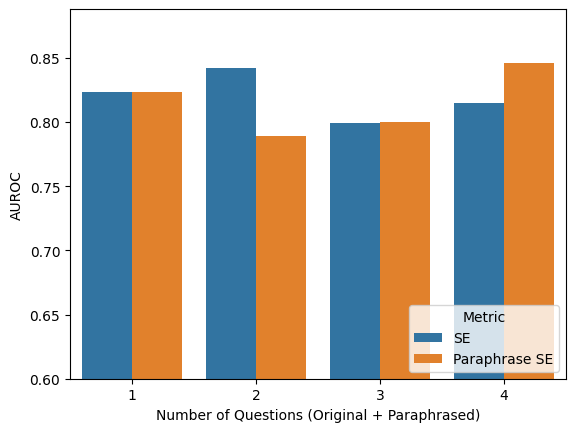

In [8]:
import seaborn as sns
ax = sns.barplot(data={"Num q":num_q_flat, "AUROC": aurocs_by_num_q_flat, "Metric": metrics_flat}, x="Num q", y="AUROC", hue="Metric")
# plt.bar([1, 2, 3, 4], auroc_by_num_q['all_semantic_entropy'])
sns.move_legend(ax, "lower right")
plt.ylim(bottom=0.6)
plt.xlabel("Number of Questions (Original + Paraphrased)")

In [9]:
len(uncertainty_measures['all_semantic_entropy']), len(uncertainty_measures['original_semantic_entropy'])

(1095, 1095)

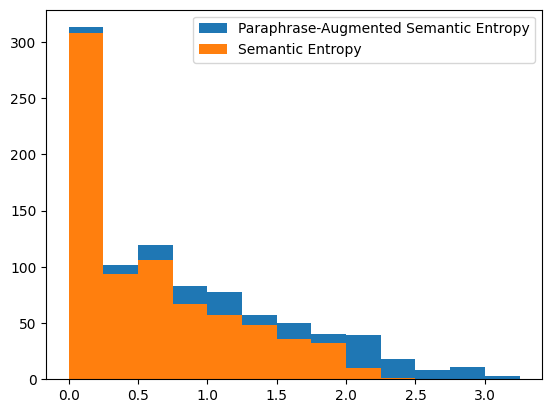

In [10]:
import numpy as np

bin_ends = np.arange(0, 3.5, 0.25)
plt.hist(uncertainty_measures['all_semantic_entropy'], label="Paraphrase-Augmented Semantic Entropy", alpha=1, bins=bin_ends)
plt.hist(uncertainty_measures['original_semantic_entropy'], label="Semantic Entropy", alpha=1, bins=bin_ends)
plt.legend()

In [11]:
uncertainty_results['is_false'][:10]

[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0]

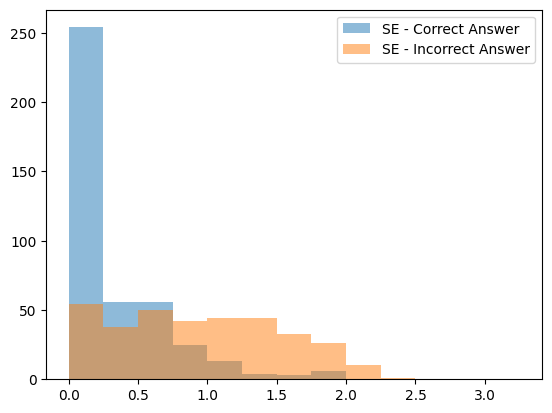

In [12]:
se_correct = np.array(uncertainty_measures['original_semantic_entropy'])[~np.array(uncertainty_results['is_false']).astype(bool)]
se_incorrect = np.array(uncertainty_measures['original_semantic_entropy'])[np.array(uncertainty_results['is_false']).astype(bool)]
pa_se_correct = np.array(uncertainty_measures['all_semantic_entropy'])[~np.array(uncertainty_results['is_false']).astype(bool)]
pa_se_incorrect = np.array(uncertainty_measures['all_semantic_entropy'])[np.array(uncertainty_results['is_false']).astype(bool)]

bin_ends = np.arange(0, 3.5, 0.25)
plt.hist(se_correct, label="SE - Correct Answer", alpha=0.5, bins=bin_ends)
plt.hist(se_incorrect, label="SE - Incorrect Answer", alpha=0.5, bins=bin_ends)
plt.legend()

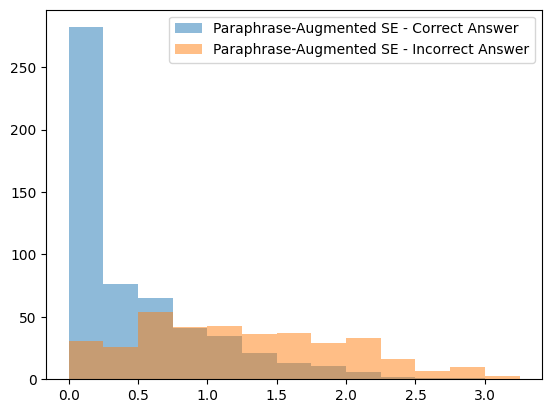

In [13]:
bin_ends = np.arange(0, 3.5, 0.25)
plt.hist(pa_se_correct, label="Paraphrase-Augmented SE - Correct Answer", alpha=0.5, bins=bin_ends)
plt.hist(pa_se_incorrect, label="Paraphrase-Augmented SE - Incorrect Answer", alpha=0.5, bins=bin_ends)
plt.legend()

In [16]:
print(np.mean(se_correct), np.mean(se_incorrect), np.mean(se_incorrect)-np.mean(se_correct))
print(np.mean(pa_se_correct), np.mean(pa_se_incorrect), np.mean(pa_se_incorrect)-np.mean(pa_se_correct))
print(np.median(se_correct), np.median(se_incorrect), np.median(se_incorrect)-np.median(se_correct))
print(np.median(pa_se_correct), np.median(pa_se_incorrect), np.median(pa_se_incorrect)-np.median(pa_se_correct))

0.16946746949737196 0.8396802086402327 0.6702127391428607
0.3491807840085231 1.1938476130903686 0.8446668290818455
0.0 0.7959199377432107 0.7959199377432107
2.2204460492503128e-16 1.108734808537291 1.1087348085372908


Text(0.5, 0, 'Paraphrase-Augmented Semantic Entropy')

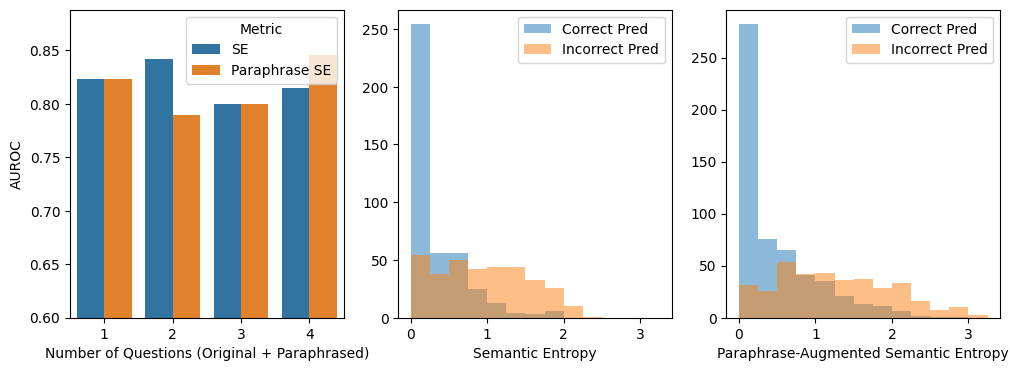

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

sns.barplot(ax=axes[0], data={"Num q":num_q_flat, "AUROC": aurocs_by_num_q_flat, "Metric": metrics_flat}, x="Num q", y="AUROC", hue="Metric")
sns.move_legend(ax, "lower right")
axes[0].set_ylim(bottom=0.6)
axes[0].set_xlabel("Number of Questions (Original + Paraphrased)")

axes[1].hist(se_correct, label="Correct Pred", alpha=0.5, bins=bin_ends)
axes[1].hist(se_incorrect, label="Incorrect Pred", alpha=0.5, bins=bin_ends)
axes[1].legend()
axes[1].set_xlabel("Semantic Entropy")

axes[2].hist(pa_se_correct, label="Correct Pred", alpha=0.5, bins=bin_ends)
axes[2].hist(pa_se_incorrect, label="Incorrect Pred", alpha=0.5, bins=bin_ends)
axes[2].legend()
axes[2].set_xlabel("Paraphrase-Augmented Semantic Entropy")

In [14]:
with open('../data/combined_uncertainty_measures_paraphrases_ablation.pkl', 'rb') as ablate_file:
    ablation_res = pickle.load(ablate_file)

with open('../data/all_paraphrase_answers.pkl', 'rb') as answers_file:
    ablation_ans = pickle.load(answers_file)

In [27]:
no_entail_check_pase = ablation_res['uncertainty_measures']['all_semantic_entropy']
entail_check_pase = ablation_res['uncertainty_measures']['valid_semantic_entropy']

len(no_entail_check_pase), len(entail_check_pase)

(579, 579)

In [29]:
no_entail_check_AUC = roc_auc_score(ablation_res['is_false'], no_entail_check_pase)
entail_check_AUC = roc_auc_score(ablation_res['is_false'], entail_check_pase)
print("With paraphrase entailment check:", entail_check_AUC)
print("Without paraphrase entailment check:", no_entail_check_AUC)

With paraphrase entailment check: 0.8523610823139125
Without paraphrase entailment check: 0.8345363363052043


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(se_correct, label="Correct Pred", alpha=0.5, bins=bin_ends)
axes[0].hist(se_incorrect, label="Incorrect Pred", alpha=0.5, bins=bin_ends)
axes[0].legend()
axes[0].set_xlabel("Semantic Entropy")

axes[1].hist(pa_se_correct, label="Correct Pred", alpha=0.5, bins=bin_ends)
axes[1].hist(pa_se_incorrect, label="Incorrect Pred", alpha=0.5, bins=bin_ends)
axes[1].legend()
axes[1].set_xlabel("Paraphrase-Augmented Semantic Entropy")